# Neural Networks from Scratch

As we have seen before, in many cases a linear hypothesis will not suffice due to the complexity of the data. Furthermore, it is usually not too obvious how to choose the correct polynomial terms for such a set of features. If we decide to include all polynomial terms, the set of features becomes too large very quickly. Neural networks offer an alternate way to perform machine learning when we have complex hypotheses with many features.

## Loading and Understanding the Data

This series of exercise make use of a handwritten digits dataset that consists of 5000 training examples, where each example is a 20 pixel by 20 pixel grayscale image of the digit. Let us first import some essential libraries.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [21]:
pwd = %pwd
pwd = pwd.replace("Notebooks", "")

The data given this time is in matlabs native extension rather than a simple txt. Fortunatelly, the scipy package has a function for this purpose. We can peek at the function using "??". 

In [22]:
??scipy.io.loadmat

In [23]:
from scipy.io import loadmat
# Use loadmat to load matlab files
mat = loadmat(pwd + "Data\\ex3data1.mat")
X = mat["X"]
y = mat["y"]

# Let's see the dimensions of the data
X.shape, y.shape

((5000, 400), (5000, 1))

As said before the dataset consists, of 5000 training examples with each being 20x20 pixels. Each 20x20 picture is unrolled into a 1 by 400 row vector, i.e. a row in our 5000 by 400 matrix corresponds to one image. The output is a 5000 long vector, where each "row" is a digit from 1 to 10 inclusive, where 10 means that the output is 0. This is due to indexing in matlab.

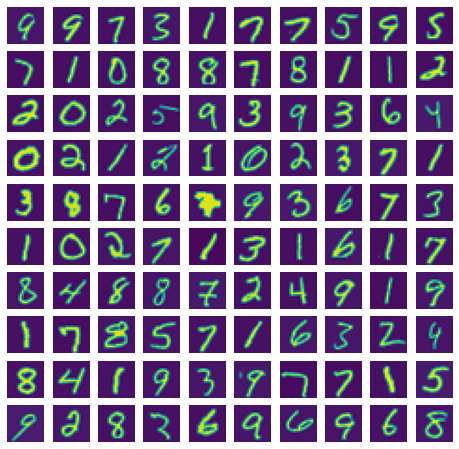

In [27]:
# Create plot of 10x10 subplots, leaving gaps
fig, axis = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        # Select random example and reshape back to 20 pixel by 20 pixel
        axis[i,j].imshow(X[np.random.randint(0, 5001), :].reshape(20, 20, order="F"))
        # Disable axis
        axis[i,j].axis("off")

## Model Representation

We will stick to the architecture used in the course, which was a 3 layered architecture, with one hidden layer having 25 units. The input layer is of course of size 400 and the output of size 10. 

Let's step trhough the computation quickly. Given:
$$X \in \mathbb{R}^{5000x400}$$
$$W^{(1)} \in \mathbb{R}^{400x25}$$
$z^{(2)}$ will be 
$$ z^{(2)} = XW^{(1)} \in \mathbb{R}^{5000x25}$$
$$ a^{(2)} = sigmoid(z^{(2)}) \in \mathbb{R}^{5000x25}$$

Now for the second part we have:
$$a^{(2)}\in \mathbb{R}^{5000x25}$$
$$W^{(2)} \in \mathbb{R}^{25x10}$$
so:
$$ z^{(3)} = a^{(2)}W^{(2)} \in \mathbb{R}^{5000x10}$$
$$ a^{(3)} = sigmoid(z^{(3)}) \in \mathbb{R}^{5000x10}$$

In [32]:
class NeuralNet(object):
    def __init__(self):        
        """ Define Hyperparameters """
        self.input_layer_size = 400
        self.hidden_layer_size = 25
        self.output_layer_size = 10
        
        # Weights
        self.W1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.W2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
    def sigmoid(self, z):
        """ Apply sigmoid activation function to scalar, vector, or matrix """
        return 1 / (1 + np.exp(-z))
        
    def forward(self, X):
        """ Propogate inputs though network """        
        # Hidden layer Activation
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        
        # Output layer Activation
        self.z3 = np.dot(self.a2, self.W2)
        y_hat = self.sigmoid(self.z3) 
        return y_hat

Actually now we have everything in order to make a prediction, so let's do juts that. 

The prediction is: 7


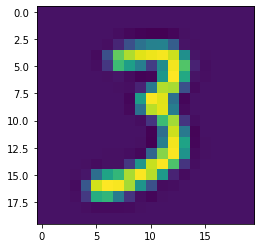

In [145]:
# Select random sample
digit = X[np.random.randint(0, 5001), :].reshape(1, 400)

# Init Neural Net
NN = NeuralNet()

# Make a prediction
y_hat = NN.forward(digit)
print (f"The prediction is: {y_hat.argmax() + 1}")

# Show result
plt.imshow(digit.reshape(20, 20, order="F"))

As we can see our model does not perform well yet, and its chances of getting the digit right are slim. Our goal now will be to train the model. First, define the cost function, where we penalise overfitting by regularisation. That is:

$$ J(\theta) =  \frac{1}{m} [-y \; log(\hat{y})^T\; - \; (\mathbb{1} - y)log(1 - \hat{y})^T ] + \frac{\lambda}{2m}  \left[ \sum (W^{(1)})^2 + \sum (W^{(2)})^2\right]$$

Where the last sums run over the whole matrix of weights.

In [170]:
def cost_function(self, X, lam):
    y_hat = NN.forward(X)
    m = X.shape[0]

    y_vec = np.zeros((m, y_hat.shape[1]))
    for i in range(m):
        if y[i] == 10:
            temp = 0
        else:
            temp = y[i]
        y_vec[i, temp] = 1

    cost = np.dot(-y_vec, np.log(y_hat).T) - np.dot((1 - y_vec), np.log(1 - y_hat).T) / m
    regularized_cost = cost + (sum(sum(self.W1**2)) + sum(sum(self.W2**2))) * (lam / 2*m)

    return regularized_cost[0, 0]

NeuralNet.cost_function = cost_function
NN.cost_function(digit, 1)

5029.389932228262

## The Gradient

We also need to compute the gradient. Let us first define the derivative of the sigmoid function:

In [171]:
def sigmoid_prime(self, z):
    """ Derivative of sigmoid function """
    return np.exp(-z) / ((1 + np.exp(-z))**2)

NeuralNet.sigmoid_prime = sigmoid_prime

Our weights, $\theta$ are spread across two matrices, $W^{(1)}$ and $W^{(2)}$. We'll separate the computation in the same way, by computing $\frac{\partial J}{\partial W^{(1)}}$ and $\frac{\partial J}{\partial W^{(2)}}$ independently. We should have just as many gradient values as weight values, so when we’re done, these matricaes will be the same size as $W^{(1)}$ and $W^{(2)}$.

$$ \frac{\partial J(\theta)}{\partial W^{(2)}} = \frac{\partial J(\theta)}{\partial a^{(3)}} \frac{\partial a^{(3)}}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial W^{(2)}}$$

$$\frac{\partial J(\theta)}{\partial a^{(3)}} = \frac{1 - y}{1 - a^{(3)}} - \frac{y}{a^{(3)}}$$

As I implemented above, the next partial is the derivative of the sigmoid function and is:

$$\frac{\partial a^{(3)}}{\partial z^{(3)}} = a^{(3)} (1 - a^{(3)})$$
$$$$
Finally:
$$\frac{\partial z^{(3)}}{\partial W^{(2)}} = a^{(2)}$$

From which we obtain:
$$ \frac{\partial J(\theta)}{\partial W^{(2)}} = (a^{(3)} - y) a^{(2)} $$

The calculation for $\frac{\partial J}{\partial W^{(2)}}$ is somewhat longer, but involves the some of the same coefficients.
$$ \frac{\partial J(\theta)}{\partial W^{(1)}} = \frac{\partial J(\theta)}{\partial a^{(3)}} \frac{\partial a^{(3)}}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial W^{(1)}} $$
Where we have already computed the first two.

$$\frac{\partial z^{(3)}}{\partial a^{(2)}} = W^{(2)}$$
$$$$
and similarly as above
$$$$
$$\frac{\partial a^{(2)}}{\partial z^{(2)}} = a^{(2)} (1 - a^{(2)})$$
$$$$
Finally
$$ \frac{\partial z^{(2)}}{\partial W^{(1)}} = X$$

Putting it together we obtain:
$$ \frac{\partial J(\theta)}{\partial W^{(1)}} = (a^{(3)} - y) W^{(2)} a^{(2)} (1 - a^{(2)}) X$$